## Evaluation of Calibration Methods

The human bias is in some ways encoded in the dataset, and models built using these datasets might amplify the bias and this could lead to a potential harm agaist unprivileged groups. The aim of this work is to prevent or mitigate the bias, and for that we evaluate the performance of several calibration methods independently of each other and see if the bias is reduced or not. Additionally we explore fairness combining several calibrarion methods in the same pipeline. For this purposes we are going to use aif360 package.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
from time import time

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

from utils import *

### 1. Load data

For the analysis we are going to use the Homicide  Reports,  1980-2014 dataset (https://www.kaggle.com/murderaccountability/homicide-reports).   The  data  was  compiled and made available by the Murder Accountability Project, founded by ThomasHargrove. 

In [2]:
data = pd.read_csv('../data/database.csv', na_values=['Unknown', ' '])

Before computing the metrics for fairness measurement, we first preprocess the data.

### 2. Preprocessing

In [3]:
print('Data dimensions are:', data.shape)

Data dimensions are: (638454, 24)


In [4]:
data.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,NaN,Male,15.0,Native American/Alaska Native,NaN,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,NaN,Male,42.0,White,NaN,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,NaN,Male,42.0,White,NaN,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,1,FBI


In [5]:
# Removing non useful columns
data.drop(columns=['Record ID', 'Agency Code', 'Perpetrator Ethnicity'], inplace=True)

In [6]:
# Getting rid off non solved cases, since we are interested on the impact of solved incidents.
print(data['Crime Solved'].value_counts())
data = data[data['Crime Solved'] == 'Yes']

Yes    448172
No     190282
Name: Crime Solved, dtype: int64


In [7]:
data.shape

(448172, 21)

In [8]:
# To get more insights we build Perpetrator Age Category
# We'll consider the following
# > 65 'Elder', < 25 'Young' and 'Adult' if >= 25 and <= 65
data['Perpetrator Age category'] = 'Missing'
data['Perpetrator Age category'] = np.where(data['Perpetrator Age'] > 64, 'Elder', np.where(data['Perpetrator Age'] < 25, 'Young', 'Adult'))

In [9]:
data['Perpetrator Age category'].unique()

array(['Young', 'Adult', 'Elder'], dtype=object)

In [10]:
# Lets create catergorical and numerical variable
skip = ['Crime Solved', 'Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']

num_columns, cat_columns = get_columns(data, skip)

#### Handling missing values

In [11]:
# Number of missing values
data.isna().sum()

Agency Name                     33
Agency Type                      0
City                             0
State                            0
Year                             0
Month                            0
Incident                         0
Crime Type                       0
Crime Solved                     0
Victim Sex                     331
Victim Age                       0
Victim Race                   3592
Victim Ethnicity            255032
Perpetrator Sex                147
Perpetrator Age                  0
Perpetrator Race              6049
Relationship                 94892
Weapon                       18409
Victim Count                     0
Perpetrator Count                0
Record Source                    0
Perpetrator Age category         0
dtype: int64

In [12]:
# We are going to fill with median values 
median_val = pd.Series()
for col in num_columns:
    if col not in ['Crime Solved']:
        median_val[col] = data[col].median()

In [13]:
data = handle_missing_values(data, median_val)

#### Visualization

We will choose **Perpetrator Sex** and **Perpetrator Race** as our target variables, so let's see the distributions of this variables

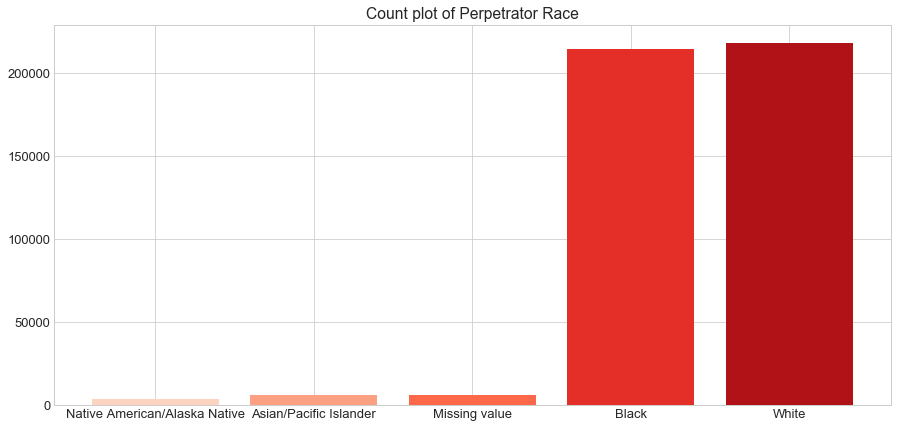

In [14]:
target_distribution(y_var='Perpetrator Race', data=data)

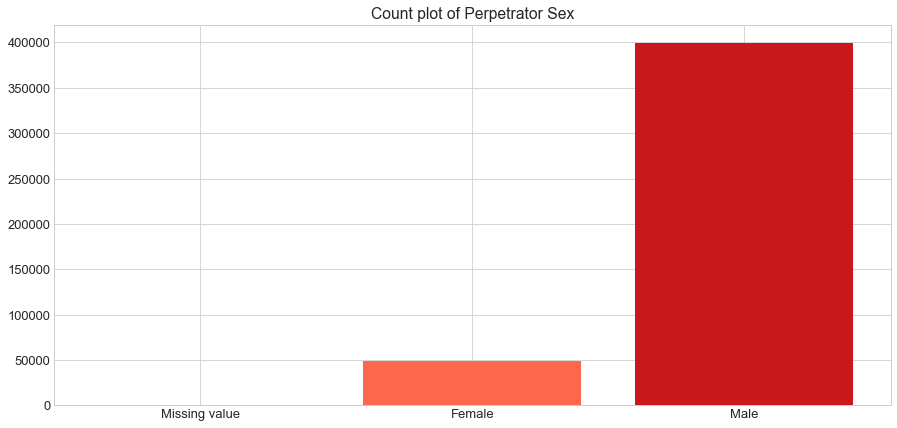

In [15]:
target_distribution(y_var='Perpetrator Sex', data=data)

Additionally we will see for the **Perpetrator Age Category**

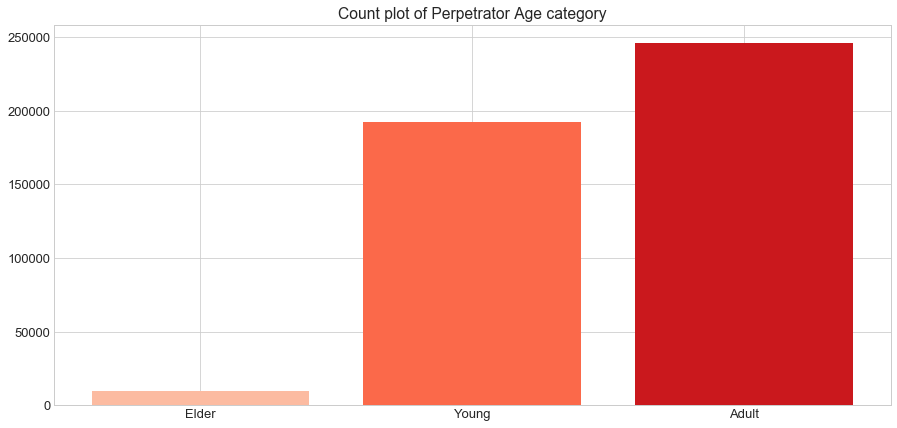

In [16]:
target_distribution(y_var='Perpetrator Age category', data=data)

In [17]:
# Let's see the frecuency of crimes for the target variables
data['Frequency'] = 1
freq_target = data[['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category', 'Frequency']]
del data['Frequency']
freq_target = freq_target.groupby(by=['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']).count() / len(data)
print(freq_target.sort_values(by='Frequency', ascending=False))

                                                                        Frequency
Perpetrator Sex Perpetrator Race              Perpetrator Age category           
Male            White                         Adult                      0.264265
                Black                         Young                      0.220366
                                              Adult                      0.197418
                White                         Young                      0.159222
Female          Black                         Adult                      0.035841
                White                         Adult                      0.034741
                Black                         Young                      0.018415
                White                         Young                      0.013767
Male            White                         Elder                      0.013439
                Missing value                 Young                      0.008546
                

#### Handling outliers

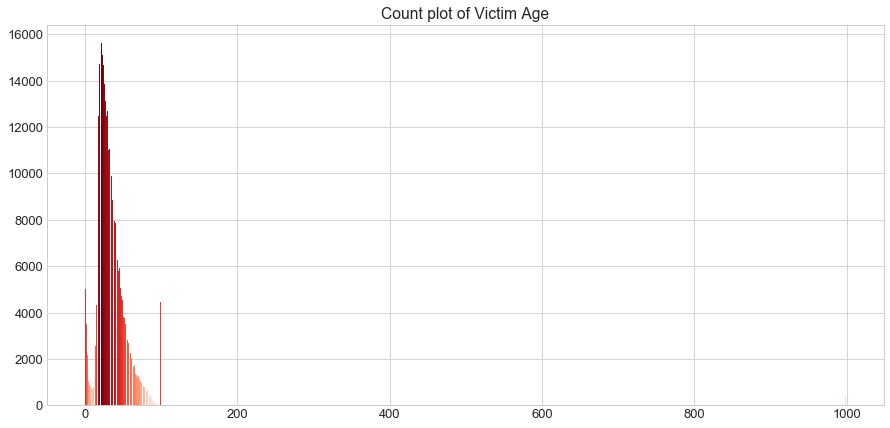

In [18]:
# Let's check on ages
target_distribution(y_var='Victim Age', data=data)

In [19]:
data['Victim Age'].describe()

count    448172.000000
mean         34.008200
std          32.806341
min           0.000000
25%          22.000000
50%          30.000000
75%          42.000000
max         998.000000
Name: Victim Age, dtype: float64

From the plot and the summary of **Victim Age** shown above, we can see that we have outliers

In [20]:
data['Victim Age'] = np.where(data['Victim Age'] == 998, np.median(data[data['Victim Age'] <= 100]['Victim Age']), data['Victim Age'])

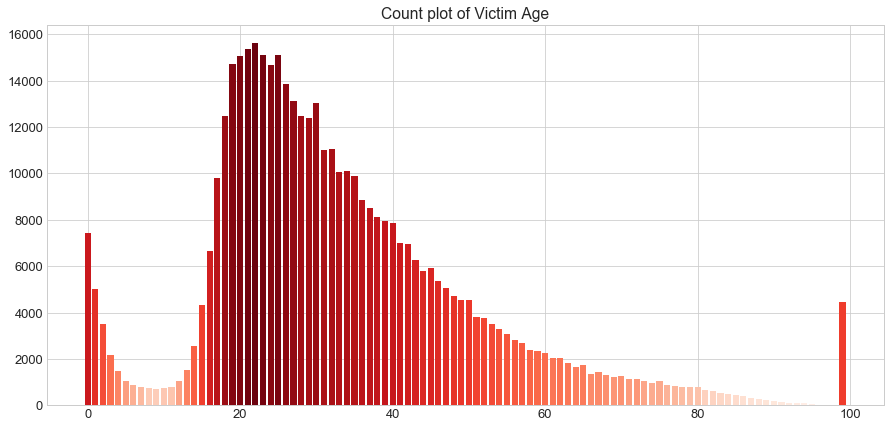

In [21]:
target_distribution(y_var='Victim Age', data=data)

Now is much better

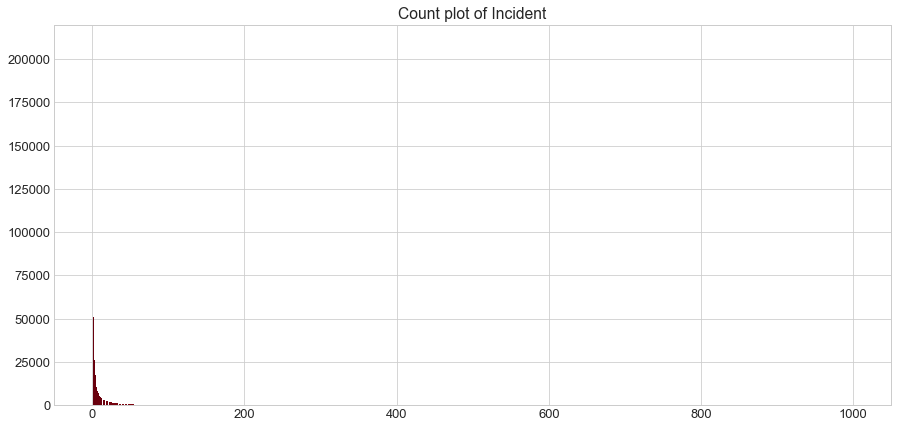

In [22]:
# Let's see the distribution of 'Incident'
target_distribution(y_var='Incident', data=data)

We can see that this variable is useless, so let's drop it

In [23]:
# Variables to drop
data.drop(['Incident', 'Crime Solved'], axis=1, inplace=True)

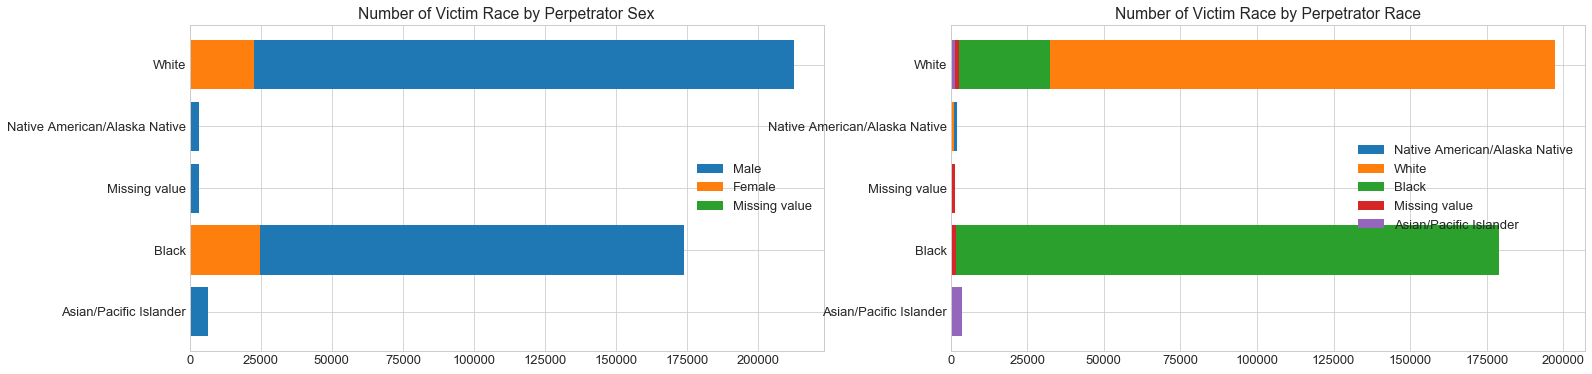

In [24]:
# Vis of Target variable against 'protected features'
Y_columns = ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']
plot_bar(data, col='Victim Race',Y_columns=Y_columns)

#### Encoding Categorical Features

To work with the different metrics or any other algorithms, we need to encode our categorical variables to numerical values

In [25]:
categorical_features = cat_columns + ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category'] 
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]


In [26]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le

In [27]:
# We also need to scale the values, to work with neural network based models (we'll see later)
numerical_features = [c for c in data.columns.values if c not in categorical_features]

for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms
    
data_encoded = data_encoded.astype(float)

del num_columns

### 3. Bias Measure

For this part we are going to use aif360 library provided by IBM

In [28]:
# We have set 2 target variables, but first we are going to start with 'Perpetrator Sex'
data_perp_sex = data_encoded.drop(['Perpetrator Race','Perpetrator Age category','Perpetrator Age'], axis=1)

In [29]:
# Indicate the privileged groups
privileged_sex = np.where(categorical_names['Victim Sex'] == 'Male')[0]
privileged_race = np.where(categorical_names['Victim Race'] == 'White')[0]

In [30]:
data_orig_sex = StandardDataset(data_perp_sex, 
                               label_name='Perpetrator Sex', 
                               favorable_classes=[1], 
                               protected_attribute_names=['Victim Sex', 'Victim Race'], 
                               privileged_classes=[privileged_sex, privileged_race])

In [31]:
# Split data in train and test set
np.random.seed(42)

data_orig_sex_train, data_orig_sex_test = data_orig_sex.split([0.7], shuffle=True)


#### Model training

Some of the metrics we are going to use needs the posterior $\hat{Y}$, so we are going to train a model

In [32]:
# Train and save the models
rf_orig_sex = RandomForestClassifier().fit(data_orig_sex_train.features, 
                     data_orig_sex_train.labels.ravel(), 
                     sample_weight=data_orig_sex_train.instance_weights)

In [33]:
# Prediction
X_test_sex = data_orig_sex_test.features
y_test_sex = data_orig_sex_test.labels.ravel()

Accuracy of the model : 0.9349805134918038
F1 score of the model : 0.9645513158428287


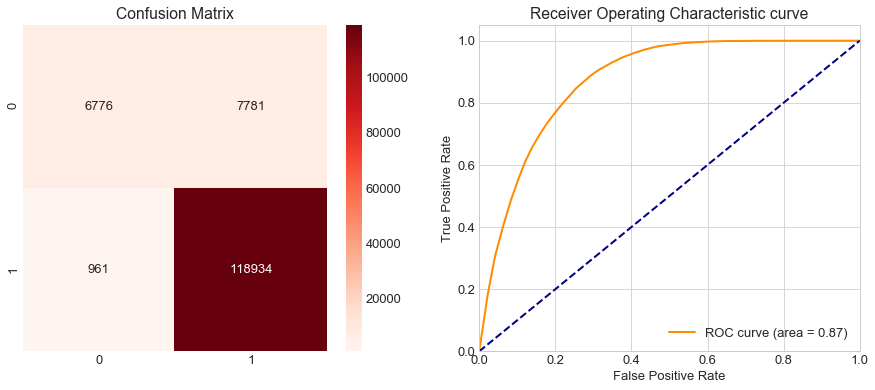

In [34]:
plot_model_performance(rf_orig_sex, data_orig_sex_test.features, data_orig_sex_test.labels.ravel())

#### Metrics

Now we measure the bias in the dataset, refer to the [project report](https://github.com/jwilliamn/calibration-methods-for-fairness/blob/master/Fairness_in_Machine_Learning_and_the_Evaluation_of_Calibration_Methods.pdf) for more details

In [35]:
# Data frame to append the metrics
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

### Check bias metrics :

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Victim Sex,0.028145,-0.006480,0.136502,1.030085,0.026875
Victim Race,0.011949,-0.000254,0.019952,1.012569,0.026875


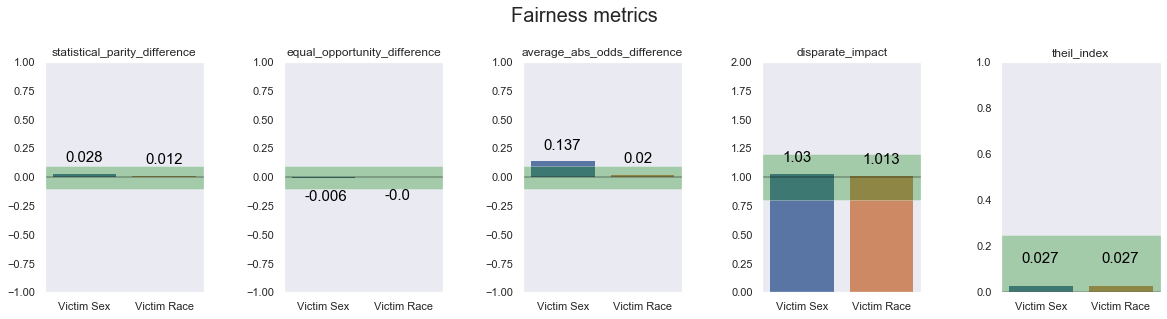

In [36]:
# Metric scores 
fair = get_fair_metrics_and_plot(data_orig_sex_test, rf_orig_sex)

As we see in the results above, **Average absolute odds difference** metric show bias towards Victim Sex feature.

In [37]:
data_orig_test = data_orig_sex_test
data_orig_train = data_orig_sex_train
rf = rf_orig_sex

probs = rf.predict_proba(data_orig_test.features)
preds = rf.predict(data_orig_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')

### 4. Calibration methods

In section 3 we have seen that we need to mitigate the existence bias in the dataset,

#### 4.1 Pre-processing algorithms

We are going to evalaute the following algorithms

##### 4.1.1 Learning fair representations

In [ ]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Sex'])
t0 = time()

LFR_model = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, k=1, verbose=0)
# LFR.fit(data_orig_train)
data_transf_train = LFR_model.fit_transform(data_orig_train)

# Train and save the model
rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = LFR_model.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_transf_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'LFR')
print('time elapsed : %.2fs'%(time()-t0))

In [39]:
fair

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.0,0.0,1.000000,0.0
Victim Sex,0.000831,0.0,0.0,1.263092,0.0
Victim Race,-0.001176,0.0,0.0,0.704457,0.0


##### 4.1.2 Reweighing

In [ ]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Sex'])
t0 = time()

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

# Train and save the model
rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = RW.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_orig_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'Reweighing')
print('time elapsed : %.2fs'%(time()-t0))

In [41]:
fair

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Victim Sex,0.027963,-0.006826,0.137195,1.029891,0.026752
Victim Race,0.010193,-0.000729,0.011373,1.010723,0.026752


#### 4.2 In-processing algorithms

The general idea is to add regulatization to the models.

##### 4.2.1 Adversarial Debiasing

In [43]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Sex'])
t0 = time()

# sess.close()
# tf.reset_default_graph()
sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          num_epochs=10,
                          debias=True,
                          sess=sess)

debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'AdvDebiasing')
print('time elapsed : %.2fs'%(time()-t0))




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





epoch 0; iter: 0; batch classifier loss: 92.137421; batch adversarial loss: 0.806124
epoch 0; iter: 200; batch classifier loss: 14.211414; batch adversarial loss: 0.759167
epoch 0; iter: 400; batch classifier loss: 4.579508; batch adversarial loss: 0.651951
epoch 0; iter: 600; batch classifier loss: 0.640510; batch adversarial loss: 0.584599
epoch 0; iter: 800; batch classifier loss: 0.538065; batch adversarial loss

In [44]:
fair

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Victim Sex,-0.000051,-0.000034,0.000130,0.999949,0.032665
Victim Race,-0.000467,0.000000,0.003086,0.999533,0.032665


##### 4.2.2 Prejudice Remover 

In [ ]:
t0 = time()
debiased_model = PrejudiceRemover(sensitive_attr="Victim Sex", eta = 25.0)
debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'PrejudiceRemover')
print('time elapsed : %.2fs'%(time()-t0))

#### 4.3 Post-processing algorithms

The general idea is to calibrate the output of the model.

In [45]:
data_orig_test_pred = data_orig_test.copy(deepcopy=True)

# Prediction with the original RandomForest model
scores = np.zeros_like(data_orig_test.labels)
scores = rf.predict_proba(data_orig_test.features)[:,1].reshape(-1,1)
data_orig_test_pred.scores = scores

preds = np.zeros_like(data_orig_test.labels)
preds = rf.predict(data_orig_test.features).reshape(-1,1)
data_orig_test_pred.labels = preds

def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1-probs1)
    return np.concatenate((probs0, probs1), axis=1)

##### 4.3.1 Calibrated Equality of Odds

In [ ]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Sex'])
t0 = time()

cost_constraint = "fnr" # "fnr", "fpr", "weighted"

CPP = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

CPP = CPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = CPP.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_orig_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      CPP, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'CalibratedEqOdds')
print('time elapsed : %.2fs'%(time()-t0))

In [47]:
fair

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Victim Sex,0.028145,-0.006480,0.136502,1.030085,0.026875
Victim Race,0.011949,-0.000254,0.019952,1.012569,0.026875


##### 4.3.2 Reject Option 

In [48]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Sex'])
t0 = time()

ROC = RejectOptionClassification(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups)

ROC = ROC.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = ROC.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      ROC, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'RejectOption')
print('time elapsed : %.2fs'%(time()-t0))

/Users/jaspersw./anaconda3/envs/py37/lib/python3.7/site-packages/aif360/algorithms/postprocessing/reject_option_classification.py:160: UserWarning:

Unable to satisy fairness constraints



IndexError: index 0 is out of bounds for axis 0 with size 0

In [49]:
fair

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Victim Sex,0.028145,-0.006480,0.136502,1.030085,0.026875
Victim Race,0.011949,-0.000254,0.019952,1.012569,0.026875


#### 4.4 Comparison of the algorithms

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
Origin,0.011949,-0.000254,0.019952,1.012569,0.026875
LFR,-0.001176,0.000000,0.000000,0.704457,0.000000
Reweighing,0.010193,-0.000729,0.011373,1.010723,0.026752
AdvDebiasing,-0.000467,0.000000,0.003086,0.999533,0.032665
CalibratedEqOdds,0.011949,-0.000254,0.019952,1.012569,0.026875


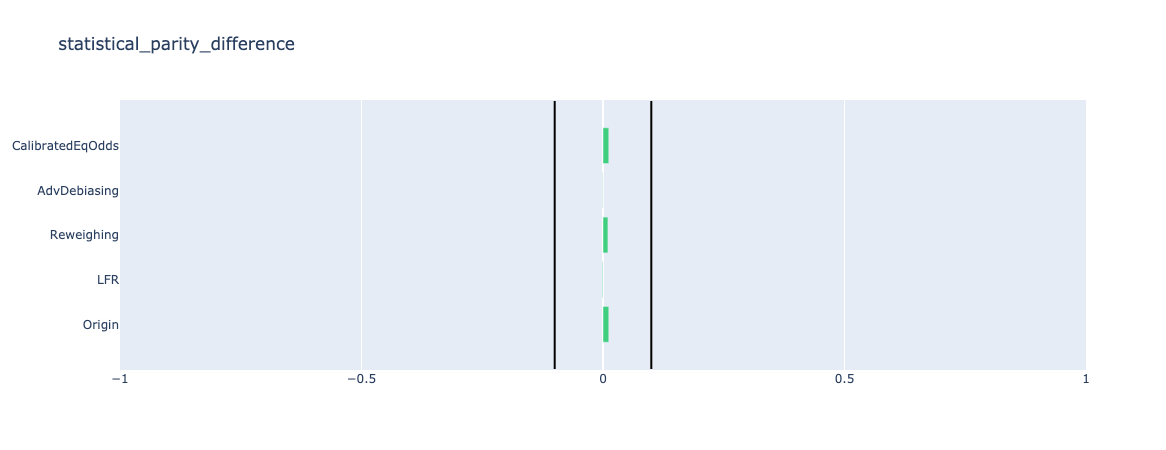

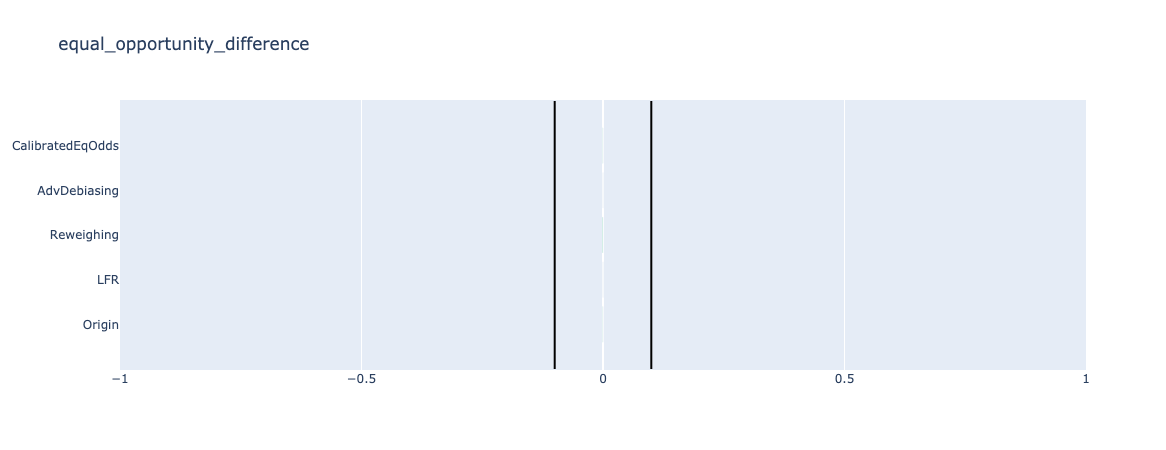

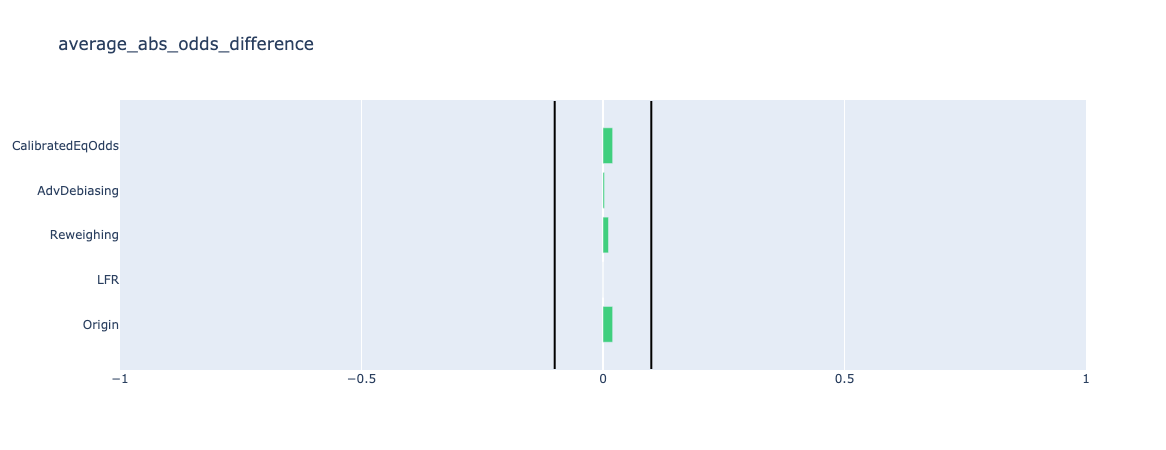

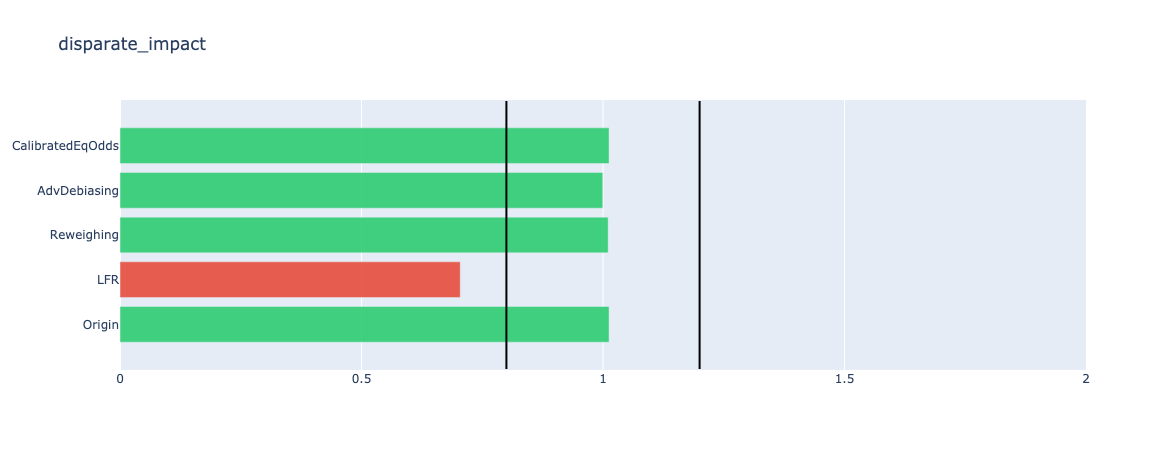

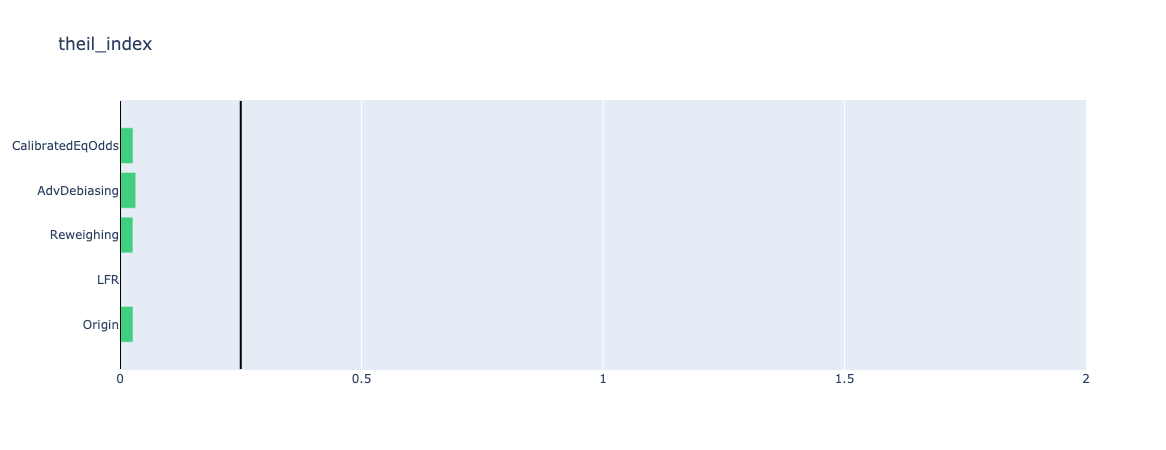

,score,nb_valid
AdvDebiasing,0.036686,5.0
Reweighing,0.059771,5.0
Origin,0.071599,5.0
CalibratedEqOdds,0.071599,5.0
LFR,0.296720,3.0


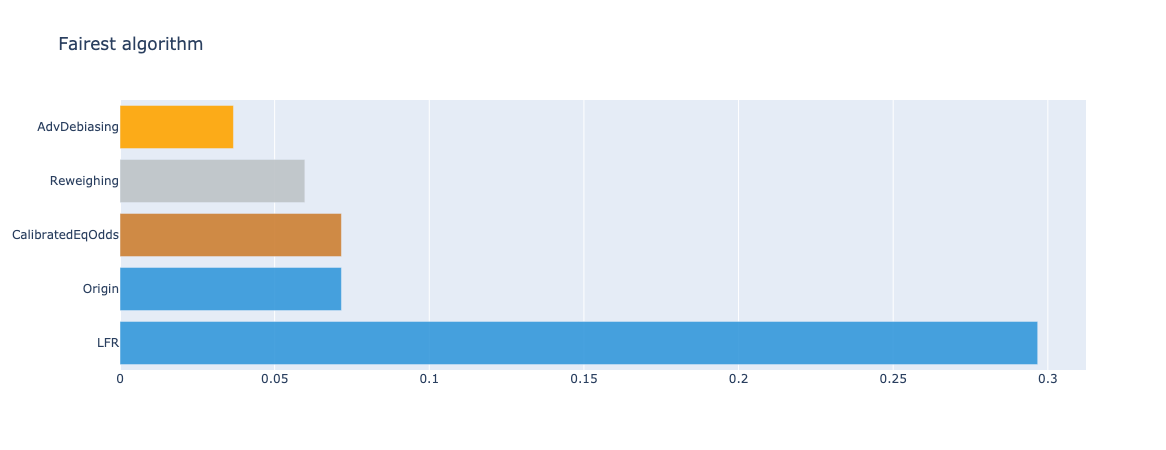

In [50]:
compare_fair_metrics(algo_metrics)

#### 4.5 Comparison of the algorithms

,Accuracy,F1 Score
Reweighing,0.935211,0.964675
Origin,0.934981,0.964551
LFR,0.801074,0.887807
CalibratedEqOdds,0.732343,0.832395


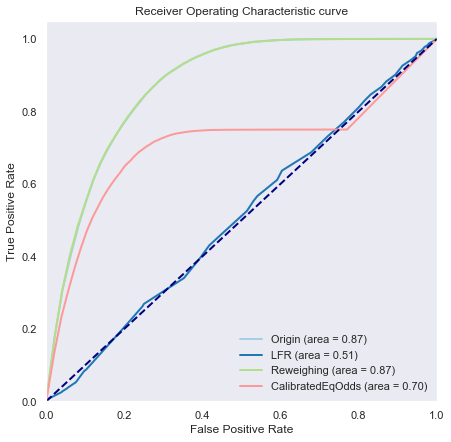

,Accuracy,F1 Score
Origin,0.934981,0.964551
LFR,0.801074,0.887807
Reweighing,0.935211,0.964675
CalibratedEqOdds,0.732343,0.832395


In [51]:
plot_compare_model_performance(algo_metrics, data_orig_test)